# Importing libraries

We will start the analysis by importing the required packages for the analysis

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.graph_objs._figure import Figure

# Importing the data

Next step is to  import the dataset we will analyse. 

The [Global Terrorism Database](https://www.bing.com/ck/a?!&&p=8d52447addc9f399JmltdHM9MTcyMDQ4MzIwMCZpZ3VpZD0xNDk2N2Q5YS1mZTA4LTY5NjMtMWZhYS02ZTQwZmZlODY4Y2EmaW5zaWQ9NTIwMw&ptn=3&ver=2&hsh=3&fclid=14967d9a-fe08-6963-1faa-6e40ffe868ca&psq=what+is+the+global+terrorism+database&u=a1aHR0cHM6Ly93d3cuc3RhcnQudW1kLmVkdS9ndGQv&ntb=1) (GTD) is an open-source database that includes information on terrorist events worldwide from 1970 through 2020. 

The one that will be used here hold records up to December 2017.

In [2]:
df = pd.read_csv("globalterrorismdb_0718dist.csv", encoding='ansi', low_memory=False) # note the struggle to find the correct encoding
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181691 entries, 0 to 181690
Columns: 135 entries, eventid to related
dtypes: float64(55), int64(22), object(58)
memory usage: 187.1+ MB


eventid  iyear  imonth  iday approxdate  extended resolution  country  \
0  197000000001   1970       7     2        NaN         0        NaN       58   
1  197000000002   1970       0     0        NaN         0        NaN      130   
2  197001000001   1970       1     0        NaN         0        NaN      160   
3  197001000002   1970       1     0        NaN         0        NaN       78   
4  197001000003   1970       1     0        NaN         0        NaN      101   

          country_txt  region  ... addnotes scite1 scite2  scite3  dbsource  \
0  Dominican Republic       2  ...      NaN    NaN    NaN     NaN      PGIS   
1              Mexico       1  ...      NaN    NaN    NaN     NaN      PGIS   
2         Philippines       5  ...      NaN    NaN    NaN     NaN      PGIS   
3              Greece       8  ...      NaN    NaN    NaN     NaN      PGIS   
4               Japan       4  ...      NaN    NaN    NaN     NaN      PGIS   

   INT_LOG  INT_IDEO INT_MISC INT_ANY  related  
0        0         0        0       0      NaN  
1        0         1        1       1      NaN  
2       -9        -9        1       1      NaN  
3       -9        -9        1       1      NaN  
4       -9        -9        1       1      NaN  

[5 rows x 135 columns]

## Comment
- The encoding of the dataset is not the default *utf-8*. Because we are working with a dataset that lack support for *utf-8*, we tried *ansi* as the encoding (and it proved successful).
- The dataset is very large with 181,690 entries x 135 columns and more than 187 MB in memory usage. Using the web-available codebook of the GTD dataset, we will select the columns that might be relevant to our analysis

# Assessing the data

Now, we will assess some basic informations on the dataset and select the relevant columns for our analysis. 

Before that, let's remnind ourseleves the goals of this exploratory analysis:
- Find out sweetspots for terrorism, if any
- Find out securities issues, if any

In [3]:
# duplicate count
print(f"There is {df.duplicated().sum()} rows in the dataset.")
# NA count
print(f"There is {df.isna().sum().sum():,} missing values in the dataset")

There is 0 rows in the dataset.
There is 13,854,004 missing values in the dataset


## Comment
- "13 millions missing observations" is shocking at first, but make more sense when we remember the nature of our dataset. According to the codebook, a substantial amount of questions are complementary questions, that might not always apply for each records. For instance, `weaptype2` only apply when there is a second weapon used for the attack.
- Also some missing values are encoded as `-99` or `Unknown`. We will treat `-99` as missing information but will keep `Unknown` as is.
- Keeping in mind our goals, and with the help of the codebook, we will keep (and rename) the following columns for our analysis:
  - `iyear`: The year, if known, of the attack
  - `imonth`: The month, if known, of the attack
  - `iday`: The day, if known, of the attack
  - `country_txt`: The country in which the attack occured
  - `region_txt`: The region in which the attack occured
  - `city`: The city in which the attack occured
  - `longitude`: The longitude of the attack
  - `latitude`: The latitude of the attack
  - `attacktype1_txt`: The type of attack
  - `success`: Whether or not the attack succeded
  - `targettype1_txt`: The targets of the attack
  - `gname`: The name of the group of attackant
  - `nkill`: The number of death from the attack
  - `nwound`: The number of wounded people from the attack
- Note: in order to make sure that we are working with only terrorist attacks, we'll filter the dataset with record we have no doubt consistute a terrorist attack using the column `doubtterr` (`0` -> no doubt this is a terrosist act.)

# Cleaning the dataset

In [4]:
# filtering for sure terrosit acts
df = df.query("doubtterr == 0")
# filtering out and renaming for the columns to keep
cols_to_keep = [
    'iyear',
    'imonth',
    'iday',
    'country_txt',
    'region_txt',
    'city',
    'longitude',
    'latitude',
    'attacktype1_txt',
    'weaptype1_txt',
    'success',
    'targtype1_txt',
    'gname',
    'nkill',
    'nwound',
]
cols_rename = [
    'year',
    'month',
    'day',
    'country',
    'region',
    'city',
    'longitude',
    'latitude',
    'attack_type',
    'weapon_type',
    'success',
    'target_type',
    'group_name',
    'n_kill',
    'n_wound'
]
print(f"We hand-curated {len(cols_to_keep)} columns for the analysis.")
# filtering and renaming
df = df[cols_to_keep]
df.rename(
    dict(zip(cols_to_keep, cols_rename)),
    axis=1,
    inplace=True
)
# replacing -99/"-99" and "Unknown" by na
df.replace(["-99", -99, ""], pd.NA, inplace=True)
# converting str to lower and replacing "unknown"
df[df.select_dtypes(include='object').columns] = (
    df[df.select_dtypes(include='object').columns].apply(
        lambda x: x.str.lower()
    ).replace('unkwown', pd.NA)
)
# converting string back to title
df[df.select_dtypes(include='object').columns] = (
    df[df.select_dtypes(include='object').columns].apply(
        lambda x: x.str.title()
    )
)
# info on data
df.info()
df.head()

We hand-curated 15 columns for the analysis.
<class 'pandas.core.frame.DataFrame'>
Index: 138905 entries, 0 to 181690
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   year         138905 non-null  int64  
 1   month        138905 non-null  int64  
 2   day          138905 non-null  int64  
 3   country      138905 non-null  object 
 4   region       138905 non-null  object 
 5   city         138510 non-null  object 
 6   longitude    136025 non-null  float64
 7   latitude     136025 non-null  float64
 8   attack_type  138905 non-null  object 
 9   weapon_type  138905 non-null  object 
 10  success      138905 non-null  int64  
 11  target_type  138905 non-null  object 
 12  group_name   138905 non-null  object 
 13  n_kill       132137 non-null  float64
 14  n_wound      127951 non-null  float64
dtypes: float64(4), int64(4), object(7)
memory usage: 17.0+ MB


year  month  day             country                       region  \
0  1970      7    2  Dominican Republic  Central America & Caribbean   
1  1970      0    0              Mexico                North America   
2  1970      1    0         Philippines               Southeast Asia   
3  1970      1    0              Greece               Western Europe   
5  1970      1    1       United States                North America   

            city   longitude   latitude                  attack_type  \
0  Santo Domingo  -69.951164  18.456792                Assassination   
1    Mexico City  -99.086624  19.371887  Hostage Taking (Kidnapping)   
2        Unknown  120.599741  15.478598                Assassination   
3         Athens   23.762728  37.997490            Bombing/Explosion   
5          Cairo  -89.176269  37.005105                Armed Assault   

  weapon_type  success                  target_type  \
0     Unknown        1  Private Citizens & Property   
1     Unknown        1      Government (Diplomatic)   
2     Unknown        1          Journalists & Media   
3  Explosives        1      Government (Diplomatic)   
5    Firearms        1                       Police   

                           group_name  n_kill  n_wound  
0                              Mano-D     1.0      0.0  
1  23Rd Of September Communist League     0.0      0.0  
2                             Unknown     1.0      0.0  
3                             Unknown     NaN      NaN  
5                  Black Nationalists     0.0      0.0

# Feature engineering
We'll create a feature that represent the total number of casualty by adding the number of death (`n_kill`) and the number of wounded (`n_wound`)

In [5]:
df["casualty"] = df["n_kill"] + df["n_wound"]

# Exploratory Data Analysis
## Descriptive statistics

In [6]:
# summary of the quantitative variables
df.describe(include=np.number)

year          month            day      longitude  \
count  138905.000000  138905.000000  138905.000000  136025.000000   
mean     2003.965307       6.461358      15.519139      30.651849   
std        12.870088       3.395801       8.807846      55.959442   
min      1970.000000       0.000000       0.000000    -157.858333   
25%      1992.000000       4.000000       8.000000       8.737554   
50%      2010.000000       6.000000      15.000000      44.002258   
75%      2014.000000       9.000000      23.000000      69.147011   
max      2017.000000      12.000000      31.000000     179.366667   

            latitude        success         n_kill        n_wound  \
count  136025.000000  138905.000000  132137.000000  127951.000000   
mean       23.873462       0.882546       2.254160       3.549742   
std        18.290887       0.321962      10.930708      40.656933   
min       -53.154613       0.000000       0.000000       0.000000   
25%        11.840929       1.000000       0.000000       0.000000   
50%        31.637821       1.000000       0.000000       0.000000   
75%        34.599868       1.000000       2.000000       2.000000   
max        74.633553       1.000000    1384.000000    8191.000000   

            casualty  
count  127588.000000  
mean        5.564896  
std        47.246029  
min         0.000000  
25%         0.000000  
50%         1.000000  
75%         4.000000  
max      9574.000000

### Comment
- In average `88.25%` of the terrorist attacks succeed, with an average of `2` deaths and `4` wounded for each attack.
- However, it is extremely important to note that up to `50%` of the records have 0 casualty (death or wounded) and a maximun recorded value of `9,574`. Therefore the average of `6` casualty per attacks is not representative. It is affected by a few highly deadly attacks.

In [7]:
# summary of the quantitative variables
df.describe(include=object)

country                      region     city        attack_type  \
count   138905                      138905   138510             138905   
unique     202                          12    29348                  9   
top       Iraq  Middle East & North Africa  Baghdad  Bombing/Explosion   
freq     21695                       39396     7221              74075   

       weapon_type                  target_type group_name  
count       138905                       138905     138905  
unique          12                           22       3123  
top     Explosives  Private Citizens & Property    Unknown  
freq         77363                        37314      61674

### Comment
- When it comes to the location of the terrorist attacks, the `Middle East & North Africa`, epecially `Baghdad` in `Iraq` are the most affected.
- The most common type of attack is `bombing` on `private citizens & property`, perpetred by `unknown groups`

## Temporal analysis : Number of attacks & casualties across time

Now we will have a look at the trend of the number of attacks and casualty observed.

Before starting we'll create a funtion that will help us identify the highest peak of the different time series we will plot and get the data in the appropriate format

In [8]:
def highlight_peak(fig: Figure, show_legend: bool=True):
    """ 
    Highlight the maximum value of the series plotted.
    """
    for _, data in enumerate(fig.data):
        # Find the index of the maximum value
        max_index = data.y.argmax()
        max_value = data.y[max_index]
    
        # adding a scatter trace for the peak
        fig.add_scatter(
            x=[data.x[max_index]],
            y=[max_value],
            mode='markers',
            marker=dict(size=5), 
            showlegend=show_legend,            
            name=f"Peak of {data.name} in {data.x[max_index]}: {max_value:,.0f}"         
        )
    return fig

In [9]:
# extracting relevant data from table
## on a general level
attack = df[['year', 'casualty', 'success']].groupby(
    'year'
).agg(
    {
        'year':'count',
        'casualty': ['sum', 'mean'],
        'success': 'mean'
    }
)
attack['success'] *= 100
# flatten columns
attack.columns = 'number_attacks number_casualties average_casualties success_rate'.split()

## by region
attack_region = df[['year', 'region', 'casualty', 'success']].groupby(
    ['year', 'region']
).agg(
    {
        'year':'count',
        'casualty': ['sum', 'mean'],
        'success': 'mean'
    }
)
# flatten columns
attack_region.columns = 'number_attacks number_casualties average_casualties success_rate'.split()

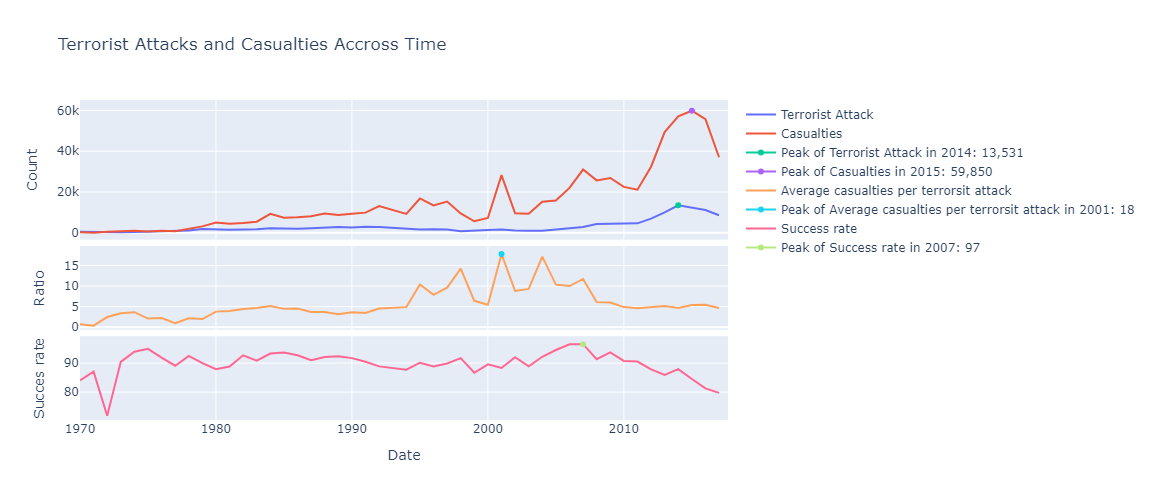

In [10]:
# plotting attack/casualty and avg casualty per attack

## attacks and casualties
line_att_cas = px.line(
    data_frame=attack,
    x=attack.index,
    y=['number_attacks', 'number_casualties']
)
# changing the names in the legend
line_att_cas.data[0].name = 'Terrorist Attack'
line_att_cas.data[1].name = 'Casualties'
# highlighting peak values
line_att_cas = highlight_peak(line_att_cas)

## avg casualties per attack
line_cas_per_att = px.line(
    data_frame=attack,
    x=attack.index,
    y='average_casualties',
)
# changing the names in the legend
line_cas_per_att.data[0].name = 'Average casualties per terrorsit attack'
# highlighting peak values
line_cas_per_att = highlight_peak(line_cas_per_att)

## success rate
line_success = px.line(
    data_frame=attack,
    x=attack.index,
    y='success_rate',
)
# changing the names in the legend
line_success.data[0].name = 'Success rate'
# highlighting peak values
line_success = highlight_peak(line_success)

## all combined 
# creating a subplot
line_attack_and_ratio = make_subplots(rows=3, cols=1, shared_xaxes=True, row_heights=[5, 3, 3], vertical_spacing=0.02)
# adding first line to the subplots
for d in line_att_cas.data:
    line_attack_and_ratio.add_trace(
        (go.Scatter(x=d['x'], y=d['y'], name = d['name'])),
        row=1, 
        col=1
    )
# adding second line to the subplots
for d in line_cas_per_att.data:
    line_attack_and_ratio.add_trace(
        (go.Scatter(x=d['x'], y=d['y'],  name = d['name'])),
        row=2,
        col=1
    )
# adding third line to the subplots
for d in line_success.data:
    line_attack_and_ratio.add_trace(
        (go.Scatter(x=d['x'], y=d['y'],  name = d['name'])),
        row=3,
        col=1
    )
# updating axes
line_attack_and_ratio.update_yaxes(title_text="Count", row=1, col=1)
line_attack_and_ratio.update_yaxes(title_text="Ratio", row=2, col=1)
line_attack_and_ratio.update_yaxes(title_text="Succes rate", row=3, col=1)
line_attack_and_ratio.update_xaxes(title_text="Date", row=3, col=1)
# updating text
line_attack_and_ratio.update_layout(
    title_text="Terrorist Attacks and Casualties Accross Time",
    width=1150,
    height=500,
)
line_attack_and_ratio.show()

#### Comment

- There has been a sharp increase in the number of terrosits attacks starting from `2005` to reach a peak of `13,531` recorded attacks in `2014`. 
- In the same fashion, the number of casualties skyrocketed in the begining of the 2000s to  reach an all-time high in `2015`
- However the average number of casualties per attack peaked in 2001 and in decreasing since. This mean that in average terrosist attack are less lethal since 2001. This make sense when we considered that the 9/11 events occured in 2001.
- On top of that the success rate of a terrorist attack is plumetting since 2007. This could be due to an improvement in security protocols to detect and prevents terrorist acts. 

## Cross-sectional analysis

### Number of attacks across region

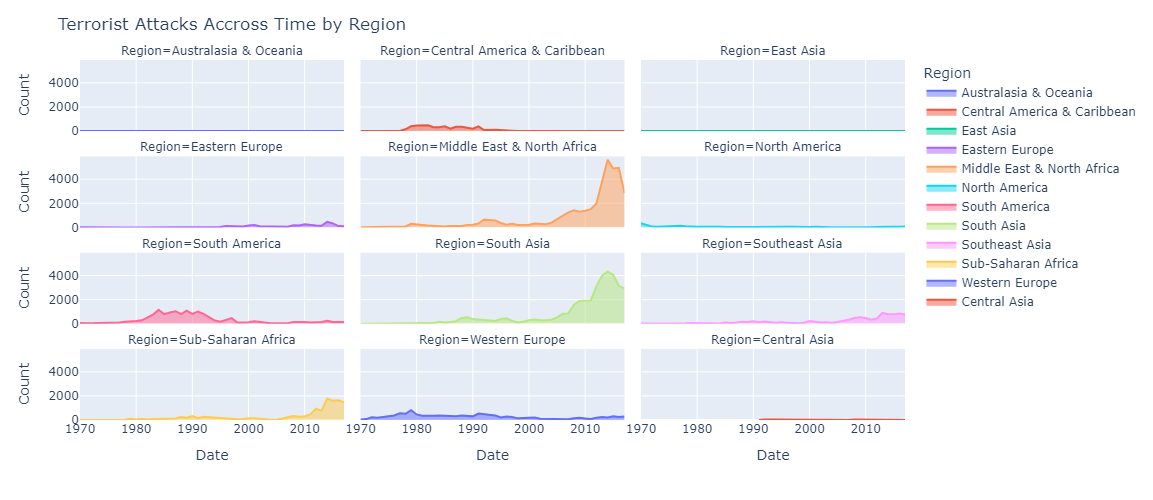

In [11]:
line_attack_region = px.area(
    data_frame=attack_region.reset_index(),
    y='number_attacks',
    x='year',
    color='region',
    labels={
        'number_attacks': 'Count',
        'year': 'Date',
        'region': 'Region'
    },
    facet_col='region',
    facet_col_wrap=3
)
line_attack_region.update_layout(
    title_text="Terrorist Attacks Accross Time by Region",
    width=1150,
    height=500,
)

line_attack_region.show()

In [12]:
# proportion of attacks in Middle East & North Africa and South Asia after 2010
top_region = attack_region.reset_index().query(
    "((region=='Middle East & North Africa') or (region=='South Asia') or (region=='Sub-Saharan Africa')) and (year>=2010)"
)['number_attacks'].sum()
world_wide = attack_region.reset_index().query("(year>=2010)")['number_attacks'].sum()
print(f"The top regions represent {top_region/world_wide*100:.2f}% of global terrorist attacks.")

The top regions represent 85.38% of global terrorist attacks.


#### Comment
- In the latest years, `Middle East & North Africa` and `South Asia` are the sweet spots for terrorism. They contribute more than `85%` of the recorded terroist attacks after 2010!

We can look a step deeper by including the country, further the city, the most targeted by terrorism.

### Most attacked region

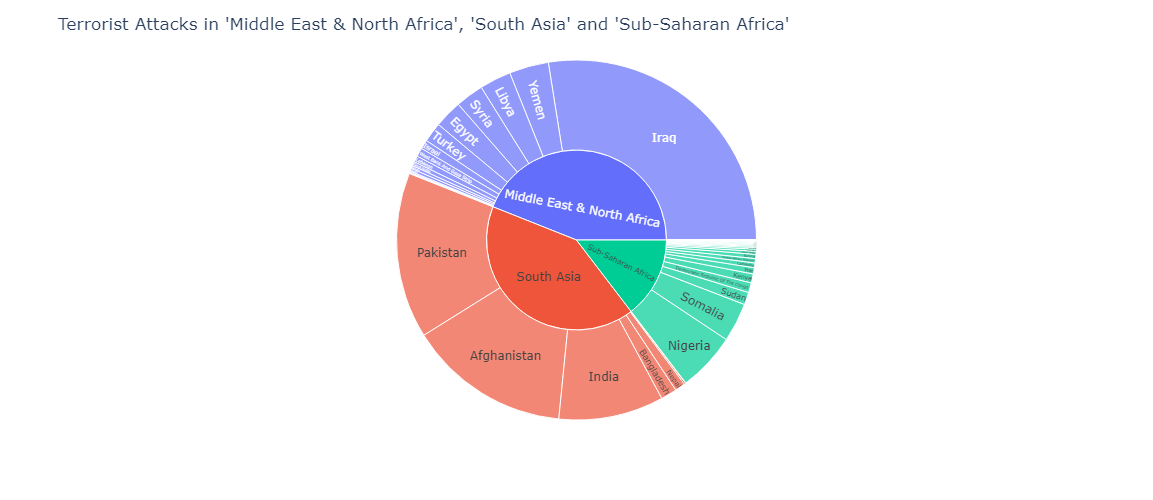

In [13]:
# filtering for the top regions
df_top_region = df.query("((region=='Middle East & North Africa') or (region=='South Asia') or (region=='Sub-Saharan Africa')) and (year>=2010)")
# plotting the top regions and country
sun_region_country = px.sunburst(
    data_frame=df_top_region['region country'.split()].dropna(),  
    path='region country'.split()
)
sun_region_country.update_layout(
    title_text="Terrorist Attacks in 'Middle East & North Africa', 'South Asia' and 'Sub-Saharan Africa'",
    width=1150,
    height=500,
)

sun_region_country.show()

#### Comment
- `Iraq` in the `Middle East & North Africa` is by far the most targeted country by terrorism, with more than twice the number of terrorist attacks in the next country, `Pakistan` in `South Asia`.
- In `Sub-Saharan Africa`, `Nigeria` is the country with the most records of terrorist attacks.

Now let's have a look at the most targeted city.

### Most attacked cities

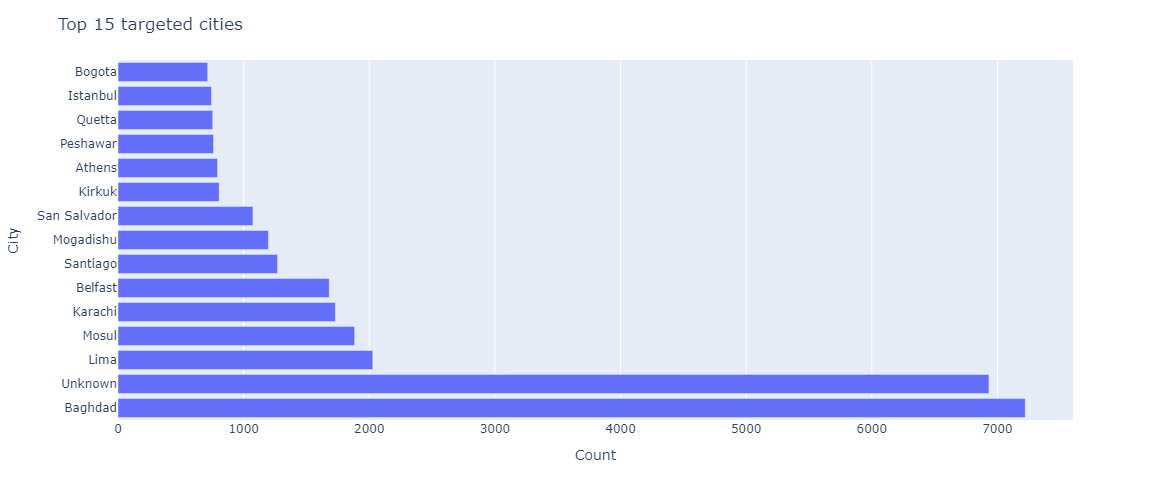

In [14]:
# getting top cities
TOP = 15
top_cities = df['city'].value_counts().reset_index()
top_n_cities = top_cities.nlargest(n=TOP, columns='count')
# bar plot of top cities
bar_city = px.bar(
    data_frame=top_n_cities,
    y='city',
    x='count',
    labels={
        'city': 'City',
        'count': 'Count',
    },
    log_x=False
)
bar_city.update_layout(
    title_text=f"Top {TOP} targeted cities",
    width=1150,
    height=500,
)
bar_city.show()

In [15]:
print("Distribution of `Unknown` cities across regions:")
df.query("city=='Unknown'")[['region']].value_counts(normalize=True)*100

Distribution of `Unknown` cities across regions:


region                     
Middle East & North Africa     26.485863
South Asia                     20.975188
South America                  12.795730
Sub-Saharan Africa             10.300058
Central America & Caribbean     9.088286
Southeast Asia                  8.857473
Western Europe                  8.698788
Eastern Europe                  1.024235
East Asia                       0.937680
North America                   0.519331
Central Asia                    0.216388
Australasia & Oceania           0.100981
Name: proportion, dtype: float64

#### Comment 
- `Baghdad` is the city with the most occurrence of terrorist attacks.
- A fair amount of attack occurs in `Unknown` cities. A deep look reveals that most of those region are located in `Middle East & North Africa`, `South Asia`, `South America` (before the 2000s) and `Sub-Saharan African`. 

### Most common targets

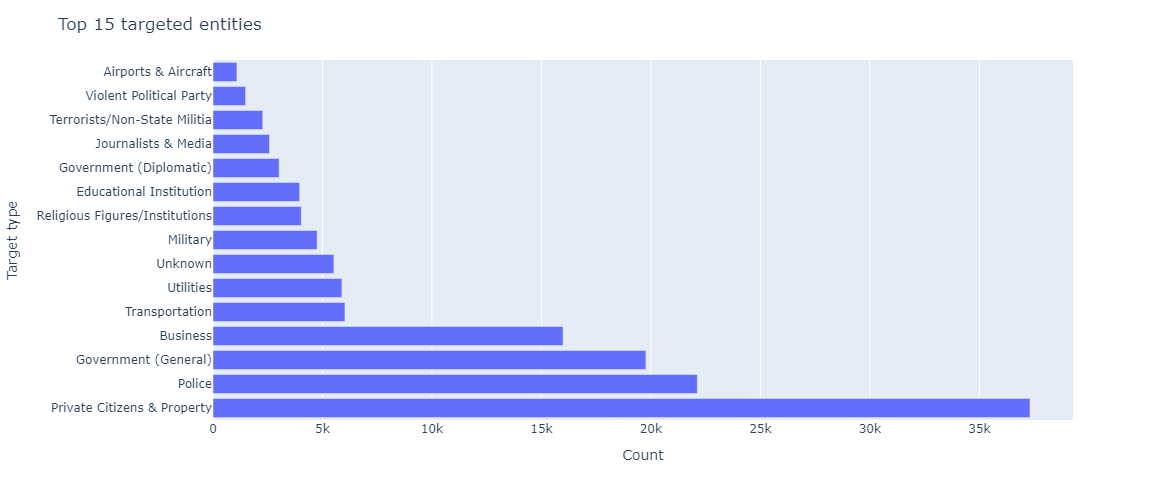

In [16]:
# getting top cities
TOP = 15
top_target = df['target_type'].value_counts().reset_index()
top_n_target = top_target.nlargest(n=TOP, columns='count')
# bar plot of top cities
bar_target = px.bar(
    data_frame=top_n_target,
    y='target_type',
    x='count',
    labels={
        'target_type': 'Target type',
        'count': 'Count',
    },
    log_x=False
)
bar_target.update_layout(
    title_text=f"Top {TOP} targeted entities",
    width=1150,
    height=500,
)
bar_target.show()

#### Comment
- `Private Citizens & Property`, `Police`, `Government` and `Businesses` are the most common targets for a terrorist attacks.

### Most common attack types

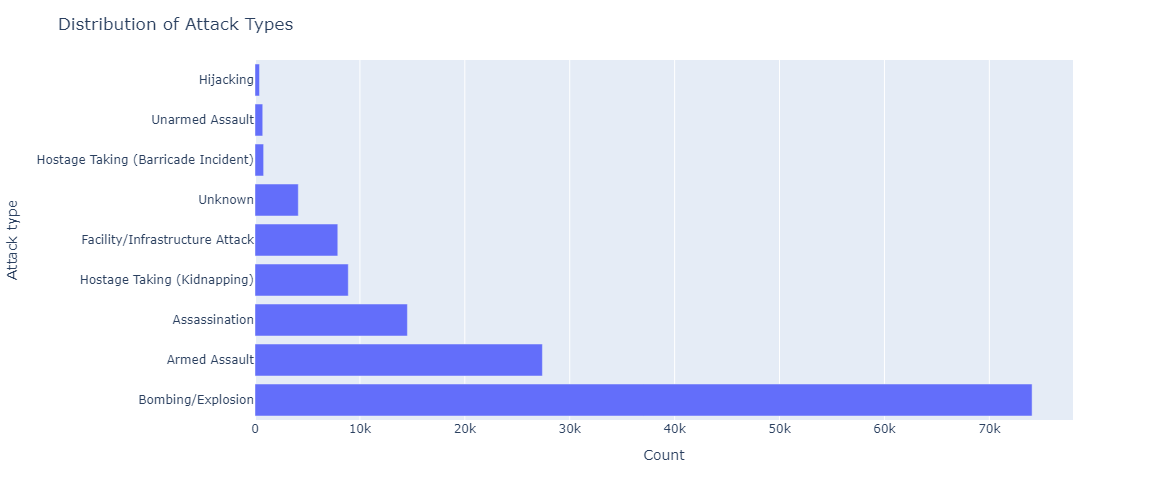

In [17]:
# getting top cities
top_n_attack = df['attack_type'].value_counts().reset_index()
# bar plot of top cities
bar_attack = px.bar(
    data_frame=top_n_attack,
    y='attack_type',
    x='count',
    labels={
        'attack_type': 'Attack type',
        'count': 'Count',
    },
    log_x=False
)
bar_attack.update_layout(
    title_text=f"Distribution of Attack Types",
    width=1150,
    height=500,
)
bar_attack.show()

#### Comment
- `Bombing/Explosion` and `Armed Assault` are the most common type of attacks.

### Most common weapon

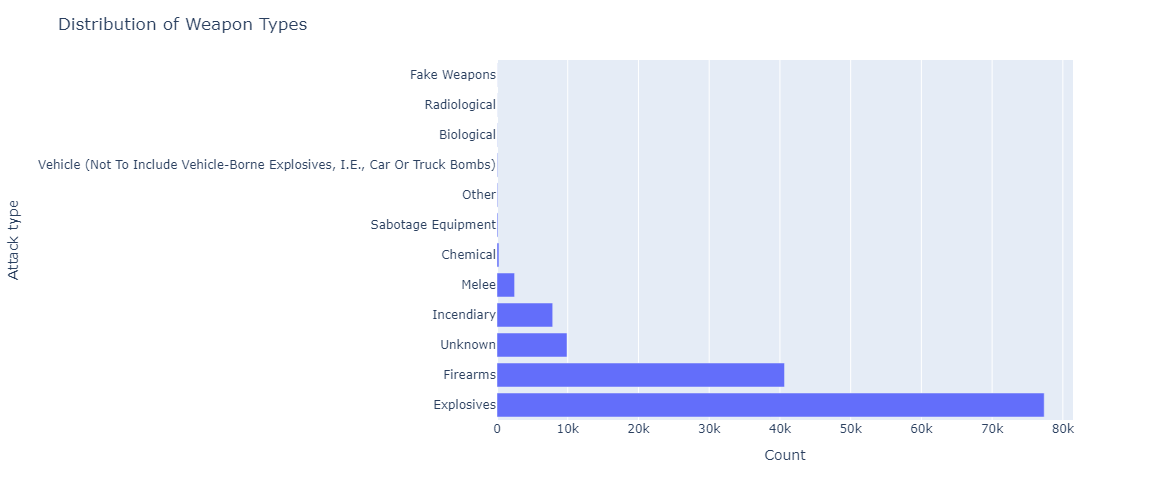

In [18]:
# getting top cities
top_n_weapon = df['weapon_type'].value_counts().reset_index()
# bar plot of top cities
bar_weapon = px.bar(
    data_frame=top_n_weapon,
    y='weapon_type',
    x='count',
    labels={
        'weapon_type': 'Attack type',
        'count': 'Count',
    },
    log_x=False
)
bar_weapon.update_layout(
    title_text=f"Distribution of Weapon Types",
    width=1150,
    height=500,
)
bar_weapon.show()

#### Comment
- `Explosives` and `Firearms` constitute the most common weapons used for a terrorist attack.

### Most active terrorist group

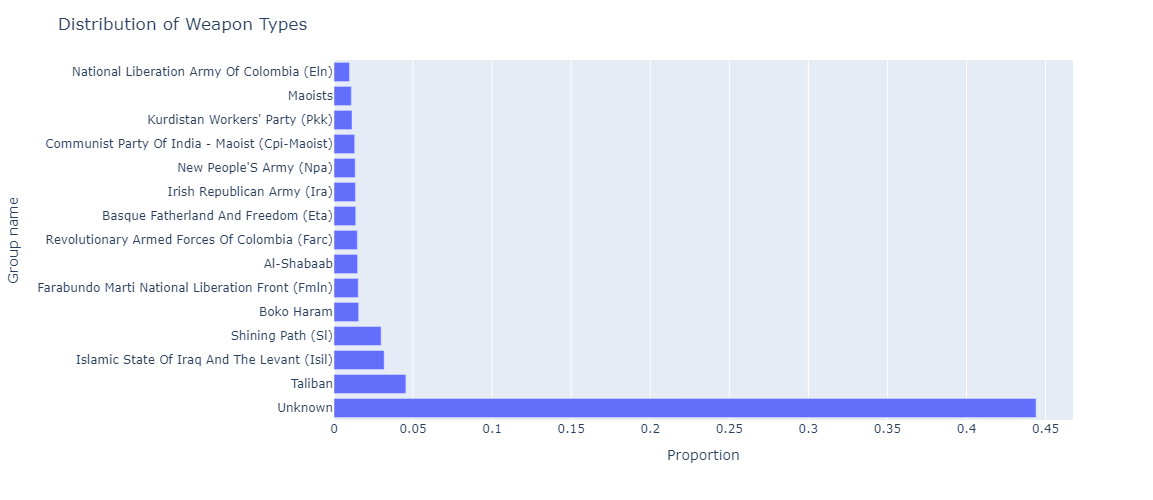

In [19]:
# getting top gname
TOP = 15
top_terror = df['group_name'].value_counts(normalize=True).reset_index()
top_n_terror = top_terror.nlargest(n=TOP, columns='proportion')
# bar plot of top gname
bar_terror = px.bar(
    data_frame=top_n_terror,
    y='group_name',
    x='proportion',
    labels={
        'group_name': 'Group name',
        'proportion': 'Proportion',
    },
    log_x=False
)
bar_terror.update_layout(
    title_text=f"Distribution of Weapon Types",
    width=1150,
    height=500,
)
bar_terror.show()

#### Comment
- Almost half of the terrorist attacks are not revendicated by any groups. But `Taliban` represents the most active known terrorist group.

## Graphical anlysis

We can also plot the different terrorist attacks to try to spot an geographical pattern. We'll consider year 2014 as this is the year with the most terrosrist attacks

In [20]:
df_geo=df.dropna(subset='casualty').query("casualty>0 & year==2014")

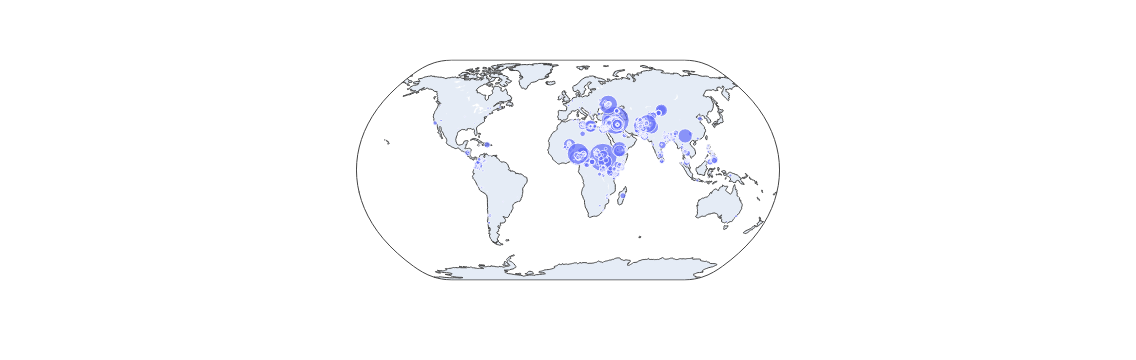

In [21]:
geo_attack=px.scatter_geo(
    data_frame=df_geo,
    lon='longitude',
    lat='latitude',
    size='casualty',
    hover_name='city',
    projection="natural earth"
)
geo_attack.show()

# Final insights

## Hotspots for Terrorism

Based on our analysis, several key hotspots for terrorism emerge:

- **Geographical Concentration**: The Middle East & North Africa (MENA), particularly Iraq, stands out as the most severely impacted region. Baghdad, within Iraq, is identified as the city with the highest frequency of terrorist attacks. This concentration underscores the critical need for enhanced security measures and international cooperation to mitigate the risks in these areas.

- **Trends Over Time**: A significant increase in terrorist activities was observed starting from 2005, peaking in 2014 with 13,531 recorded attacks. Although the overall number of attacks has slightly decreased since then, the MENA and South Asia remain the primary hotspots, accounting for over 85% of all recorded terrorist attacks post-2010.

- **Target Preferences**: Terrorist attacks predominantly target private citizens & property, police, government institutions, and businesses. This broad targeting strategy suggests a multifaceted approach is required to protect *various sectors of society*.

- **Attack Methods and Weapons**: Bombings/explosions and armed assaults are the most prevalent types of attacks, with explosives and firearms being the weapons of choice. Understanding these preferences is crucial for developing effective countermeasures and protective strategies.

- **Attribution of Attacks**: A significant portion of terrorist attacks, almost half, remains unclaimed by any group. This anonymity complicates efforts to understand the motivations behind these attacks and to attribute responsibility accurately. However, among the attacks that are claimed, the Taliban emerges as the most active known terrorist group. This finding underscores the importance of focusing on well-known groups like the Taliban in counterterrorism efforts, while also acknowledging the challenge posed by unattributed attacks.

### Security Insights

The analysis provides valuable insights for enhancing security against terrorism:

- **Casualty Analysis**: Despite the high success rate of terrorist attacks (88.25%), nearly half of the incidents result in zero casualties. However, a small number of exceptionally deadly attacks skew the average casualty figures. Focusing on preventing these high-impact attacks could significantly reduce the overall toll of terrorism.

- **Temporal Trends**: The declining trend in both the lethality of attacks and their success rate since the early 2000s indicates potential improvements in global security measures. Continued investment in intelligence, surveillance, and response capabilities is warranted to sustain and enhance these positive trends.

- **Target Hardening and Preparedness**: Given the broad range of targets, efforts should be diversified across private, public, and governmental sectors. Implementing robust security protocols, promoting awareness campaigns, and investing in advanced detection technologies are recommended strategies.

- **Regional Focus**: The disproportionate impact of terrorism in the MENA and South Asia necessitates tailored approaches that consider local contexts, including cultural, political, and socio-economic factors. International collaboration and capacity-building initiatives in these regions are critical.

- **Understanding Motivations**: The high percentage of unclaimed attacks highlights a critical gap in intelligence and underscores the need for improved methods of attack attribution. Enhancing intelligence gathering and analysis capabilities is essential to better understand the motivations and tactics of unknown perpetrators.

- **Focus on Known Groups**: While addressing the broader challenge of unclaimed attacks, continued focus on known groups such as the Taliban is crucial. Tailored strategies that account for the unique characteristics and objectives of these groups can help disrupt their operations and reduce their impact.